# BSB525 - Data Mining, Speing 2024, Final Assignment
## Alper TANRIKULU, Mehmet IZMIRLI
Hands-on application of data mining methods from preprocessing, classfication, clustering and regression.

# IMPORT NECESSARY LIBRARIES AND MODULES

In [1]:
import importlib.util
import sys

# take a list of modules, and check if they are installed
# install if not installed
def import_modules(library_imiprot_dict:dict):
    for lib in library_imiprot_dict.keys():
        imp = library_imiprot_dict[lib]
        if imp in sys.modules:
            print(f"{imp!r} already imported")
        elif (spec := importlib.util.find_spec(imp)) is not None:
            print(f"{imp!r} can be imported")
        else:
            print(f"Installing the {imp!r} module")
            !conda install --yes -q --prefix {sys.prefix} {lib}
            if (spec := importlib.util.find_spec(imp)) is not None:
                print(f"{imp!r} can be imported")
            else:
                 print(f"can't find the {imp!r} module")

In [2]:
# this only worked on wsl-conda
# instlal missing modules
libs_n_imps = {"pandas": "pandas", 
               "matplotlib": "matplotlib", 
               "re": "re", 
               "scikit-learn": "sklearn", 
               "imbalanced-learn": "imblearn", 
               "seaborn": "seaborn", 
               "scipy": "scipy",
               "colorcet": "colorcet"}

import_modules(libs_n_imps)

'pandas' can be imported
'matplotlib' can be imported
're' already imported
'sklearn' can be imported
'imblearn' can be imported
'seaborn' can be imported
'scipy' can be imported
'colorcet' can be imported


In [3]:
# we chose to import modules manually since we used some abbreviations 
# or we imported some parts of modules separately for convenience while coding
import pandas as pd
import statistics, math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import statistics
import re
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.utils.random import sample_without_replacement
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFwe, f_regression
from mpl_toolkits.mplot3d import Axes3D

------------------------------------------------

# CUSTOM FUNCTIONS

Over-sampling must only be done with the training sample to:
* Prevent the model from incorrectly classifying the samples from the underrepresented class.
* To make sure that the test set represents the actual distribution of the sampled population.

The below code implements a cross-validation procedure where only the training data is oversampled.

In [4]:
# Cross-Validation with Integrated Over-Sampling
def cross_vall_w_oversampler(X, y, estimator, splits=5, sampler = 0):
    samplers = {
        "0": RandomOverSampler(),
        "1": SMOTE()
    }
    results= {
        "fold": [],
        "Accuracy": [],
        "F-score": []
    }
    kf = KFold(n_splits=splits)
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train = X.iloc[train_index,:]
        y_train = y.iloc[train_index] 
        X_test = X.iloc[test_index,:]
        y_test = y.iloc[test_index]
        if str(sampler) in samplers.keys():
            sm = samplers[str(sampler)]
        else:
            break
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        estimator.fit(X_train_oversampled, y_train_oversampled )  
        y_pred = estimator.predict(X_test)
        results["fold"].append(fold)
        a_score = estimator.score(X_test, y_test)
        results["Accuracy"].append(a_score)
        f_score = f1_score(y_test, y_pred, average="macro")
        results["F-score"].append(f_score)

    return pd.DataFrame.from_dict(results)

The below code implements a dendrogram plotting function with the results of sklearn's AgglomerativeClustering.

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

The below code enables us to investigate the samples that fall into the same cluster(s), given a fitted clustering mode, a list of cluster IDs and the original dataframe.

In [6]:
def cluster_content(clustering_model, query_clusters_list, original_data_frame):
    cluster_indices = np.isin(clustering_model.labels_, query_clusters_list)
    og_cluster = original_data_frame.loc[cluster_indices,:]
    return og_cluster

-------------------------------------------------

# LOAD THE DATA

In this assignment, we performed several data mining techniques on [the data generated by Bourdas et al.](https://doi.org/10.1016/j.dib.2021.107480).

The dataset was put together to investigate the effect of the lockdown period during the isolation taken to measures to stop the spread of the COVID-19 pandemic on the sleeping and smoking behaviour of Greek people.


In [7]:
# load data and display
raw_data = pd.read_csv("mmc2.csv", header=0, sep=";")

display(raw_data.head())

,No,PRE_PA Daily Sporting activities (MET-min/week),PRE_Physical activity level,Age (yrs),Age classes,Weight (kg),Height (cm),BMI (kg·m‾²),BMI classes,Biological sex,PRE_Sleeping (h·day‾¹),PRE_Smoking (cigarettes·day‾¹),POST_Sleeping (h·day‾¹),POST_Smoking (cigarettes·day‾¹)
0,1.0,12480,High,19,Young,68,165,"24,97704316",Acceptable weight,Female,10.0,0.0,8.0,0.0
1,2.0,"23449,25",High,34,Adults,75,170,"25,95155709",Overweight,Female,6.0,0.0,9.0,0.0
2,3.0,"2513,125",High,39,Adults,76,163,"28,60476495",Overweight,Male,7.0,0.0,6.0,0.0
3,4.0,"2746,75",High,51,Middle-Age Adults,114,188,"32,25441376",Obese,Male,6.0,0.0,5.0,0.0
4,5.0,4778,High,25,Young,73,174,"24,11150746",Acceptable weight,Female,8.0,0.0,9.0,0.0


The data was collected from 8495 Greek people whose ages were between 18 and 79 years.
The recorded features were:
* Physical activity (PA) levels before the lockdown (MET-min/week)
* Age (years)
* Weight (kg)
* Height (cm)
* BMI (kg·m‾²)
* Biological sex
* Sleep duration before the lockdown (h·day‾¹)
* Number of cigarettes smoked before the lockdown (cigarettes·day‾¹)
* Sleep duration after the lockdown (h·day‾¹)
* Number of cigarettes smoked before the lockdown (cigarettes·day‾¹)
* Additional features that are the categorical versions of some of the above:
    * 5 Age groups: 'Young', 'Adults', 'Middle-Age Adults', 'Old Adults', '70+'.
    * 4 BMI groups: 'Underweight', 'Acceptable weight', 'Overweight', 'Obese'.
    * 4 PA groups: 'Inactive', 'Low', 'Moderate', 'High'.

While the data were intended to be used for statistical inference on the habitual changes of Greek people affected by the lockdown experience, the collected data provided a nice sandbox to practice the following procedure which was covered in the BSB525 - Data Mining class during the 2024 spring semester.

------------------------------------------------

# PREPROCESSING

Before starting the analysis, the data were preprocessed through a series of steps:
* [NA Value Removal](#Remove-NA-Values-Before-Proceeding)
* [Feature Selection](#Select-Features-That-Are-To-Be-Used-for-The-Assignment)
* [Changing Column Names](#Change-Column-Names)
* [Adjusting Column Data Types](#Adjust-Column-Data-Types-and-Formats)
* [Performing Encodings](#Perform-Encodings)
* [Handling Outliers](#Handle-Outliers)
* [Scaling The Data](#Adjust-Data-Scales)

## Remove NA Values Before Proceeding

The data had 1 row which contained NA values, and that row consisted entirely of NA values.

The record was removed from the dataset.

In [8]:
# which rows have NA values?
raw_data[raw_data.isna().any(axis=1)]

,No,PRE_PA Daily Sporting activities (MET-min/week),PRE_Physical activity level,Age (yrs),Age classes,Weight (kg),Height (cm),BMI (kg·m‾²),BMI classes,Biological sex,PRE_Sleeping (h·day‾¹),PRE_Smoking (cigarettes·day‾¹),POST_Sleeping (h·day‾¹),POST_Smoking (cigarettes·day‾¹)
8495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# drop the rows with NA values
raw_data = raw_data[~raw_data.isna().any(axis=1)]
display(raw_data)

,No,PRE_PA Daily Sporting activities (MET-min/week),PRE_Physical activity level,Age (yrs),Age classes,Weight (kg),Height (cm),BMI (kg·m‾²),BMI classes,Biological sex,PRE_Sleeping (h·day‾¹),PRE_Smoking (cigarettes·day‾¹),POST_Sleeping (h·day‾¹),POST_Smoking (cigarettes·day‾¹)
0,1.0,12480,High,19,Young,68,165,"24,97704316",Acceptable weight,Female,10.0,0.0,8.0,0.0
1,2.0,"23449,25",High,34,Adults,75,170,"25,95155709",Overweight,Female,6.0,0.0,9.0,0.0
2,3.0,"2513,125",High,39,Adults,76,163,"28,60476495",Overweight,Male,7.0,0.0,6.0,0.0
3,4.0,"2746,75",High,51,Middle-Age Adults,114,188,"32,25441376",Obese,Male,6.0,0.0,5.0,0.0
4,5.0,4778,High,25,Young,73,174,"24,11150746",Acceptable weight,Female,8.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,8491.0,4770,High,46,Adults,75,170,"25,95155709",Overweight,Female,7.0,0.0,9.0,0.0
8491,8492.0,0,Inactive,60,Old Adults,75,178,"23,67125363",Acceptable weight,Male,6.0,25.0,5.0,18.0
8492,8493.0,0,Inactive,52,Middle-Age Adults,95,175,"31,02040816",Obese,Female,8.0,40.0,8.0,45.0
8493,8494.0,0,Inactive,42,Adults,131,199,"33,07997273",Obese,Male,7.0,0.0,8.0,0.0


## Select Features That Are To Be Used for The Assignment

Next, the features to be analyzed were considered.
* PA levels before locdown and Biological sex were selected as the categorical attributes.
* Age, Weight, Height, Number of cigarettes per day before lockdown, and Duration of sleep before lockdown were selected as numeric values (continuous or discrete).

Age and Weight values were prefered over BMI, which was a variable derived from the former two, because Age and Weight were found to be more informative, since differenet combinations of them coud result in the same BIM score.

In [10]:
# get rid of uninteresting data
select_data = raw_data.drop(columns=raw_data.columns[[0,1,4,7,8,12,13]])

# move target column to most right
select_data = select_data[select_data.columns[list(range(5))+[6,5]]]


display(select_data)

,PRE_Physical activity level,Age (yrs),Weight (kg),Height (cm),Biological sex,PRE_Smoking (cigarettes·day‾¹),PRE_Sleeping (h·day‾¹)
0,High,19,68,165,Female,0.0,10.0
1,High,34,75,170,Female,0.0,6.0
2,High,39,76,163,Male,0.0,7.0
3,High,51,114,188,Male,0.0,6.0
4,High,25,73,174,Female,0.0,8.0
...,...,...,...,...,...,...,...
8490,High,46,75,170,Female,0.0,7.0
8491,Inactive,60,75,178,Male,25.0,6.0
8492,Inactive,52,95,175,Female,40.0,8.0
8493,Inactive,42,131,199,Male,0.0,7.0


## Change Column Names

The column names, or on the other hand the attribute names, were changed to simpler ones keeping the self-explanatory nature of the names for convenience in coding.

In [11]:
# change column names for convenience
select_data.columns=["PA", "Age", "Weight", "Height", "Sex", "cpd_smoke", "hpd_sleep"]
display(select_data.head())

,PA,Age,Weight,Height,Sex,cpd_smoke,hpd_sleep
0,High,19,68,165,Female,0.0,10.0
1,High,34,75,170,Female,0.0,6.0
2,High,39,76,163,Male,0.0,7.0
3,High,51,114,188,Male,0.0,6.0
4,High,25,73,174,Female,0.0,8.0


## Adjust Column Data Types and Formats

The data types were not correct for some of the columns. To correct this, each column ws inspected and the necessary adjustments were carried on.

In [12]:
# check data types
select_data.dtypes # object means mixed data types

PA            object
Age           object
Weight        object
Height        object
Sex           object
cpd_smoke    float64
hpd_sleep    float64
dtype: object

Age feature was expected to be integers but was detected to be string instead.

Also, there were a 4 records where the age was a floating point number but the decimal separator was ",".
To deal with this the values with length greater than 2 were selected. Since the maximum age was 79, these values were only the decimal ones. Then, only the decimal parts were removed, since the rest of the age data were recoded as integers, per usual.

Then, whole column was converted into numeric type.

In [13]:
# Check values that have length > 2, either values greater than 99 or with decimals
print(select_data["Age"][select_data["Age"].str.len() > 2])

# There are Age values with decimal years. Convert them to integers by removing ",.."
select_data["Age"] = select_data["Age"].apply(lambda x: re.sub(",.*", "", str(x)))

# Then, convert all values in Age column to integer
select_data["Age"] = pd.to_numeric(select_data["Age"])

2984    20,4
5887    19,5
6698    20,5
8086    20,4
Name: Age, dtype: object


Similarly Weight and Height features were expected to be numerical but were detected to be strings instead.

This time, however, the decimal separator "," was replaced with "." and the the values converted to numeric type, since the decimals would make more sense for these features.

In [14]:
# values are in string format and the decimal separator is ","
# replace "," by ".", and convert all values in Weight column to numeric

# for Weight
select_data["Weight"] = pd.to_numeric(select_data["Weight"].apply(lambda x: re.sub(",", ".", str(x))))
display(select_data["Weight"])

# for Height
select_data["Height"] = pd.to_numeric(select_data["Height"].apply(lambda x: re.sub(",", ".", str(x))))
display(select_data["Height"])

0        68.0
1        75.0
2        76.0
3       114.0
4        73.0
        ...  
8490     75.0
8491     75.0
8492     95.0
8493    131.0
8494     66.0
Name: Weight, Length: 8495, dtype: float64

0       165.0
1       170.0
2       163.0
3       188.0
4       174.0
        ...  
8490    170.0
8491    178.0
8492    175.0
8493    199.0
8494    164.0
Name: Height, Length: 8495, dtype: float64

In [15]:
# Confirm coolumn data types
select_data.dtypes

PA            object
Age            int64
Weight       float64
Height       float64
Sex           object
cpd_smoke    float64
hpd_sleep    float64
dtype: object

## Perform Encodings

To be able to perform the analysis methods, the data were encoded using appropriate approaches.

To start with, the distribution of cpd_smoke (cigarettes per day smoke - before lockdown) feature was inspected.

<Axes: xlabel='cpd_smoke'>

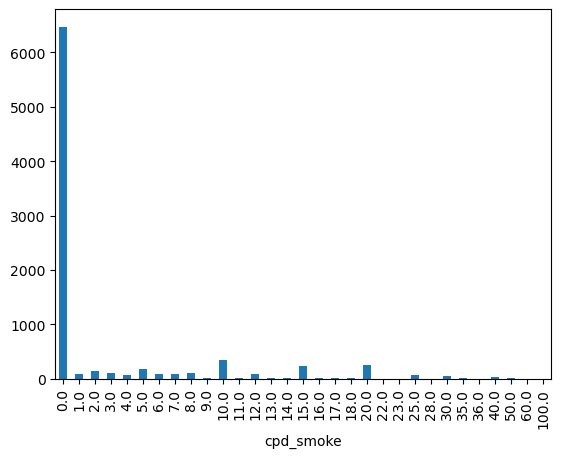

In [16]:
select_data["cpd_smoke"].value_counts(sort=False).sort_index().plot(kind="bar")

cpd_smoke feature distribution showed that non-smokers dominate the data points, with only a residual number of records for each number of cigarettes in smokers.
Thus, we tried to categorize it to ease the impact of the non-smokers on the rest of the data.

In [17]:
# target (hpd_sleep) is numerical/continuous (time in hours), convert it into categories
select_data["cpd_smoke"] = pd.cut(select_data["cpd_smoke"], bins=[0, 1, 11, 21, max(select_data["cpd_smoke"])+1],
                                  labels=["none", "light", "moderate", "heavy"],
                                  include_lowest=True, right=False)

<Axes: xlabel='cpd_smoke'>

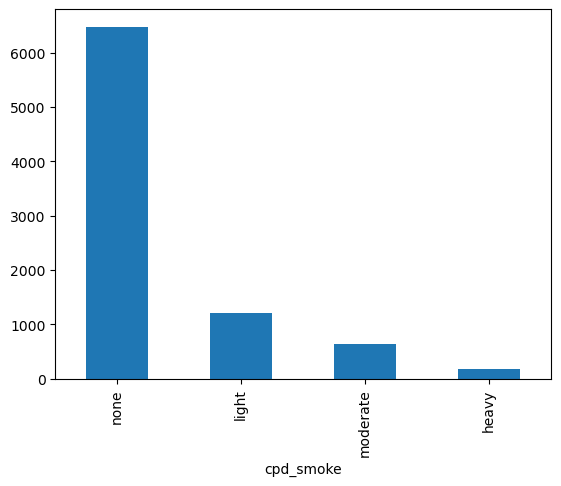

In [18]:
select_data["cpd_smoke"].value_counts(sort=False).sort_index().plot(kind="bar")

After categorization, the distribution was inspected again. It was observed that, although the non-smokers were still more than 3 times the rest, the smoker categories were still represented in reasonable numbers.

cpd_smoke and PA are categorical attributes with ordinal values. Thus they should be encoded with an OrdinalEncoder, preserving the order of values.

Also, the Sex feature can be encoded with OrdinalEncoder. Although there is no ordinal property, there are only two values so they would be assigned 0 and 1.

In [19]:
# to encode the categorical features
# create the ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        # use OrdinalEncoder for cpd_smpke, PA and Sex
        ('encoder_or', OrdinalEncoder(categories=[["none", "light", "moderate", "heavy"]]), ['cpd_smoke']),
        ('encoder_or2', OrdinalEncoder(), ['Sex']),
        ('encoder_or1', OrdinalEncoder(categories=[['Inactive', 'Low', 'Moderate', 'High']]), ['PA'])])


encoded_data = pd.DataFrame(encoder.fit_transform(select_data))
encoded_data = pd.concat([select_data["Age"], select_data["Weight"], select_data["Height"],
                         encoded_data, select_data["hpd_sleep"]],
                         axis=1)
encoded_data.columns = ["Age", "Weight", "Height", "cpd_smoke", "Sex", "PA", "hpd_sleep"]
display(encoded_data)

,Age,Weight,Height,cpd_smoke,Sex,PA,hpd_sleep
0,19,68.0,165.0,0.0,0.0,3.0,10.0
1,34,75.0,170.0,0.0,0.0,3.0,6.0
2,39,76.0,163.0,0.0,1.0,3.0,7.0
3,51,114.0,188.0,0.0,1.0,3.0,6.0
4,25,73.0,174.0,0.0,0.0,3.0,8.0
...,...,...,...,...,...,...,...
8490,46,75.0,170.0,0.0,0.0,3.0,7.0
8491,60,75.0,178.0,3.0,1.0,0.0,6.0
8492,52,95.0,175.0,3.0,0.0,0.0,8.0
8493,42,131.0,199.0,0.0,1.0,0.0,7.0


--------------------------------------

## Handle Outliers

To identify the possible outliers, the distributions of the data were inspected.

array([<Axes: title={'center': 'hpd_sleep'}>], dtype=object)

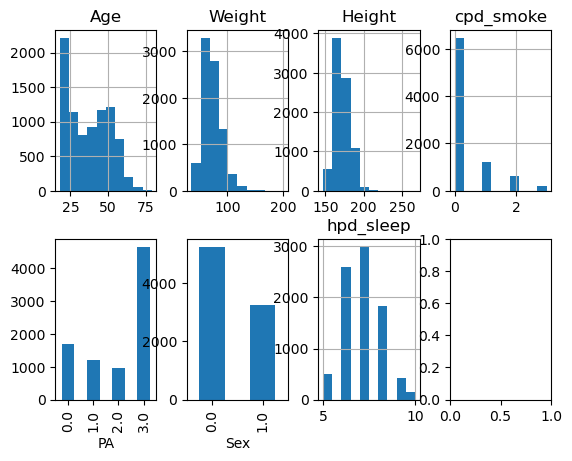

In [20]:
# inspect the distribution of numerical values
fig, axes = plt.subplots(2, 4)
        
encoded_data.hist('Age', ax=axes[0][0])
encoded_data.hist('Weight', ax=axes[0][1])
encoded_data.hist('Height', ax=axes[0][2])
encoded_data.hist('cpd_smoke', ax=axes[0][3])
encoded_data["PA"].value_counts(sort=False).sort_index().plot(kind="bar",ax=axes[1][0])
encoded_data["Sex"].value_counts(sort=False).sort_index().plot(kind="bar", ax=axes[1][1])
encoded_data.hist('hpd_sleep', ax=axes[1][2])

From the distributions, the following observations were made:
* Age distribution was bimodal wtih one peak in the smaller values, and the other on the larger values. Moreover, there were only a few people with very old ages, who were possible outliers.
* Weight and Hegiht distrbutions were similar. They both followed close to normal, and they were both right-skewed with less values at higher levels, which might be outliers.
* As discussed before non-smokers dominated the cpd_smoke feature, however few non-sokers might still be informative.
* Although the distribution of PA categories were weird, each category were represented well.
* hpd_sleep feature also followed a smilar distribution to Height and Weight.

Two methods were explored for outlier detection and elimination:

### PCA Based

The first method relied on PCA.

The first two PCAs were plotted, and the data points that lie remotely to the others were pruned.

<Axes: >

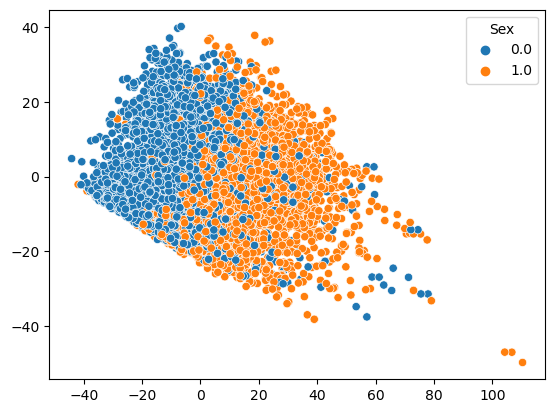

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_data)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],hue=encoded_data["Sex"])

In [22]:
print(f"number of detected outliers: {len(encoded_data.loc[pca_result[:,0]>90,:].index)}")

number of detected outliers: 3


In [23]:
non_outliers_pca = encoded_data.loc[pca_result[:,0]<90,:]

<Axes: >

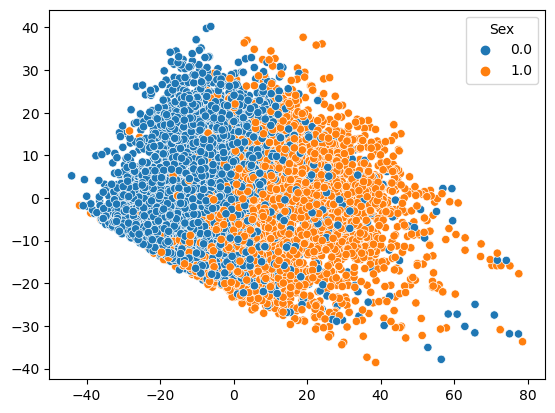

In [24]:
pca_result = pca.fit_transform(non_outliers_pca.loc[:,non_outliers_pca.columns != "Sex"])
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],hue=non_outliers_pca["Sex"])

### IsolationForest Based

Isolation Forest algorithm was used to detect and eliminate outliers. This method was chosen as an alternative for it was more robust and based than the PCA method.

The hyperparameter _contamination_ was fixed through manual trials of a range of values.

In [25]:
# Create an Isolation Forest model
i_f = IsolationForest(contamination=0.026, random_state=42) # Adjust contamination based on dataset
# Fit the model to  data
i_f.fit(encoded_data[["Age", "Weight", "Height"]])
# Predict outliers
if_results = i_f.predict(encoded_data[["Age", "Weight", "Height"]])

In [26]:
print(f"number of detected outliers: {len(encoded_data.loc[if_results<0,:].index)}")

number of detected outliers: 221


In [27]:
non_outliers_if = encoded_data.loc[if_results>0,:] 

Text(0, 0.5, 'PCA-2')

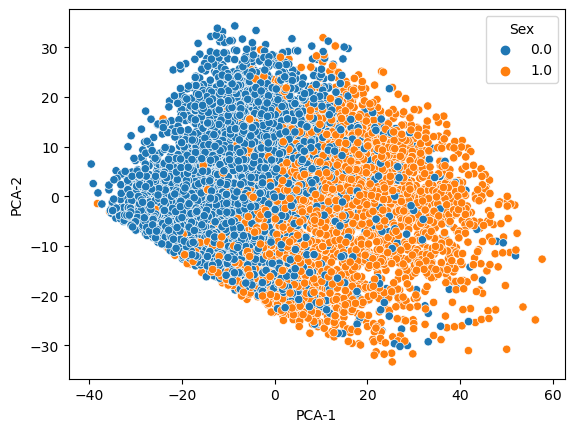

In [28]:
if_pca_result = pca.fit_transform(non_outliers_if)
sns.scatterplot(x=if_pca_result[:,0], y=if_pca_result[:,1],hue=non_outliers_if["Sex"])
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

Then, the distribution of variables were inspected side by side for the data before outlier removal, and after two different outlier detection and removal approaches.

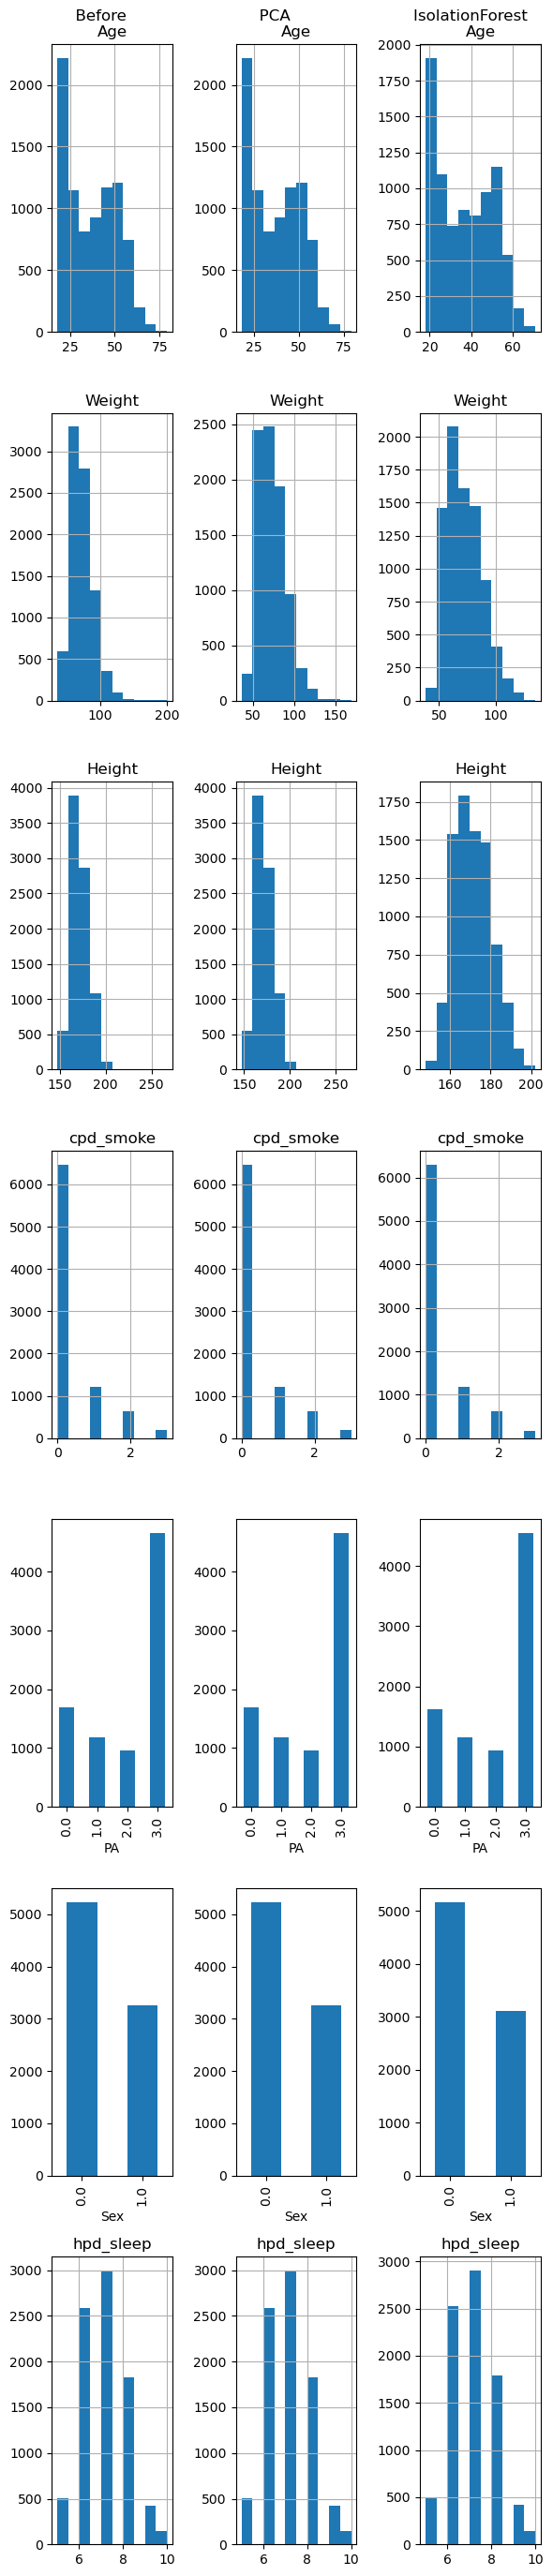

In [29]:
# inspect the distribution of numerical values
fig, axes = plt.subplots(7, 3, figsize=(6,28))

for i, x in enumerate([encoded_data, non_outliers_pca, non_outliers_if]):
    x.hist('Age', ax=axes[0][i])
    x.hist('Weight', ax=axes[1][i])
    x.hist('Height', ax=axes[2][i])
    x.hist('cpd_smoke', ax=axes[3][i])
    x["PA"].value_counts(sort=False).sort_index().plot(kind="bar",ax=axes[4][i])
    x["Sex"].value_counts(sort=False).sort_index().plot(kind="bar", ax=axes[5][i])
    x.hist('hpd_sleep', ax=axes[6][i])
fig.suptitle("          Before                           PCA                         IsolationForest")
fig.tight_layout(rect=[0, 0, 1, 0.99])

It was observed that the categorical variables were not affected much by outlier removal. Moreover, the Isolation Forest method eliminated all values represented by a few samples and kept the distributions similar.
Thus, the results of outlier removal with the Isolation Forest algorithm were used for the rest of the analysis.

In [30]:
non_outliers = non_outliers_if

---------------------------------

## Adjust Data Scales

The box-plots of the features were inspected to see the scales of the variables.

<Axes: >

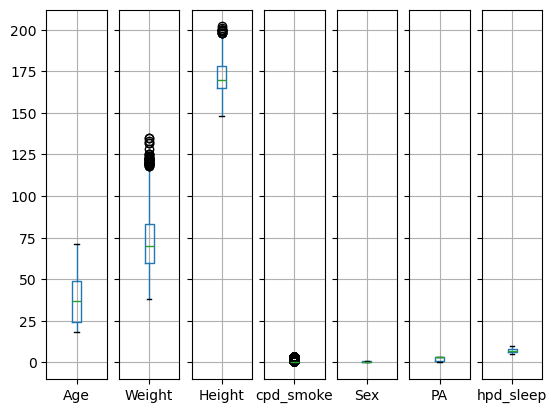

In [31]:
# inspect the distribution of numerical values
fig, axes = plt.subplots(1, 7, sharey=1)

non_outliers.boxplot('Age', ax=axes[0])
non_outliers.boxplot('Weight', ax=axes[1])
non_outliers.boxplot('Height', ax=axes[2])
non_outliers.boxplot('cpd_smoke', ax=axes[3])
non_outliers.boxplot('Sex', ax=axes[4])
non_outliers.boxplot('PA', ax=axes[5])
non_outliers.boxplot('hpd_sleep', ax=axes[6])

It was observed that the scales of features were drastically different. Thus, a Standard Scaler was applied to the data, to eliminate the effect of variable scales of features.

In [32]:
# create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # use StandardScaler for BMI, Age, and cpd_smoke
        ('scaler', StandardScaler(), ["Age", "Weight", "Height", "cpd_smoke", "Sex", "PA", "hpd_sleep"])])

preprocessor.fit(non_outliers[["Age", "Weight", "Height", "cpd_smoke", "Sex", "PA", "hpd_sleep"]])
preprocessed_data = pd.DataFrame(preprocessor.transform(non_outliers))
preprocessed_data.columns = ["Age", "Weight", "Height", "cpd_smoke", "Sex", "PA", "hpd_sleep"]
display(preprocessed_data.head())

,Age,Weight,Height,cpd_smoke,Sex,PA,hpd_sleep
0,-1.327861,-0.278781,-0.689959,-0.499391,-0.775446,0.809736,2.893502
1,-0.214282,0.170476,-0.141355,-0.499391,-0.775446,0.809736,-0.895654
2,0.156911,0.234656,-0.909401,-0.499391,1.289581,0.809736,0.051635
3,1.047775,2.673478,1.833621,-0.499391,1.289581,0.809736,-0.895654
4,-0.882429,0.042117,0.297529,-0.499391,-0.775446,0.809736,0.998924


<Axes: >

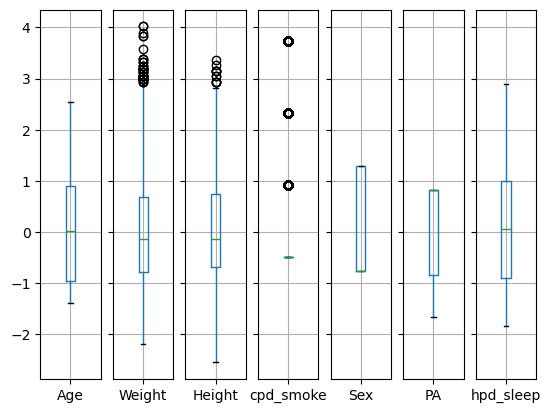

In [33]:
# inspect the distribution of numerical values
fig, axes = plt.subplots(1, 7, sharey=1)

preprocessed_data.boxplot('Age', ax=axes[0])
preprocessed_data.boxplot('Weight', ax=axes[1])
preprocessed_data.boxplot('Height', ax=axes[2])
preprocessed_data.boxplot('cpd_smoke', ax=axes[3])
preprocessed_data.boxplot('Sex', ax=axes[4])
preprocessed_data.boxplot('PA', ax=axes[5])
preprocessed_data.boxplot('hpd_sleep', ax=axes[6])

After standardization, all features approached to a similar scale with a mean of 0 and a standard deviation of 1.

There were still outliers on the box plots, however they were considered necessary corner cases for the models.

------------------------------------------------

# Classification

After the preprocessing was done, the data was used to practice the following classification methods:
1. [K-Nearest Neighbors (KNN) Classification](#K-Nearest-Neighbors-(KNN)-Classification)
2. [Decision Tree Classification](#Decision-Tree-Classification)

## Define Target and Data Parts

The target of the classification tasks was selected to be the Sex attribute. From the height, weilght, physical activity level, cigarettes smoked per day, and haours slept per day of the samples, we tried to predict their biologicla sex.

In [34]:
# Separate data and target
target_y = non_outliers["Sex"]
data_x = preprocessed_data.loc[:, preprocessed_data.columns != "Sex"]

display(target_y)
display(data_x)

0       0.0
1       0.0
2       1.0
3       1.0
4       0.0
       ... 
8489    1.0
8490    0.0
8491    1.0
8492    0.0
8494    0.0
Name: Sex, Length: 8274, dtype: float64

,Age,Weight,Height,cpd_smoke,PA,hpd_sleep
0,-1.327861,-0.278781,-0.689959,-0.499391,0.809736,2.893502
1,-0.214282,0.170476,-0.141355,-0.499391,0.809736,-0.895654
2,0.156911,0.234656,-0.909401,-0.499391,0.809736,0.051635
3,1.047775,2.673478,1.833621,-0.499391,0.809736,-0.895654
4,-0.882429,0.042117,0.297529,-0.499391,0.809736,0.998924
...,...,...,...,...,...,...
8269,0.676582,0.876451,0.955854,-0.499391,0.809736,0.051635
8270,0.676582,0.170476,-0.141355,-0.499391,0.809736,0.051635
8271,1.715923,0.170476,0.736412,3.731289,-1.660980,-0.895654
8272,1.122014,1.454067,0.407249,3.731289,-1.660980,0.998924


## Class Distribution

The disctribution of the target classes were inspected

Text(0, 0.5, 'Frequency')

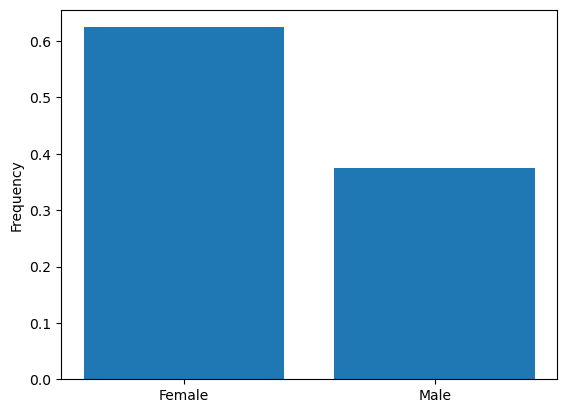

In [35]:
# check the class distribution
class_dist = target_y.value_counts(normalize=True)
class_dist.index = ["Female", "Male"]
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")

In [36]:
target_y.value_counts()

Sex
0.0    5167
1.0    3107
Name: count, dtype: int64

As can be seen, the classes were observed to be imbalanced. Thus:

* For testing/validation, it was best to use stratified sampling to preserve the observed distribution of the data.
* For model training, it was best to use over- or under-sampling to represent the minority classes better and prevent the model from misclassifying minority classes for higher accuracy.

## Stratified Subset for Parameter Tuning

Since the dataset was relatively large, parameter tuning using the whole data took too long. Moreover, after tuning the parameters, a new dataset was needed to fit the model and test its accuracy. 

Thus, a random stratified sample of 2500 data points, which was approximately 30% of the whole preprocessed data, was partitioned for the hyperparameter tuning task.

In [37]:
# make a stratified subset of 2500 samples and keep them out of the data set
# then use it for hyper-parameter tuning
data_xx, hpt_data, target_yy, hpt_target = train_test_split(
    data_x, target_y, test_size=2500, stratify=target_y, random_state=42
)

display(hpt_target.head())
display(hpt_data.head())

2140    0.0
3055    0.0
4881    0.0
1468    0.0
8277    0.0
Name: Sex, dtype: float64

,Age,Weight,Height,cpd_smoke,PA,hpd_sleep
2083,-0.288520,0.363015,-0.689959,-0.499391,-0.837408,-1.842943
2978,0.676582,-1.048935,-1.348284,-0.499391,0.809736,0.051635
4756,0.231150,2.416759,-1.238563,-0.499391,-1.660980,0.998924
1427,-0.808191,-0.984755,-0.141355,-0.499391,-1.660980,-0.895654
8060,0.528105,0.363015,0.297529,-0.499391,-0.837408,-0.895654


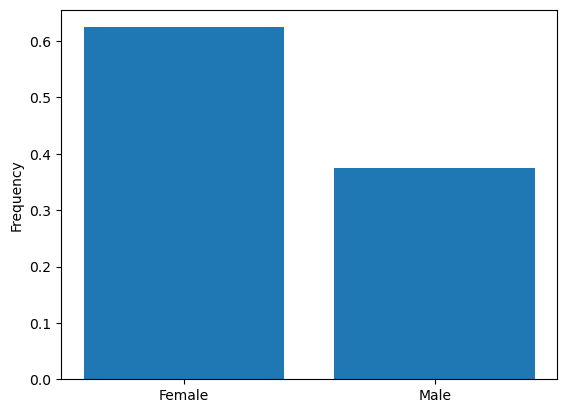

In [38]:
# check the class distribution of hyper-parameter tuning test data set
class_dist = hpt_target.value_counts(normalize=True)
class_dist.index = ["Female", "Male"]
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

## K-Nearest Neighbors (KNN) Classification

### Hyper-Parameter Tuning

4 hyper parameters were selected to determine their best values via a grid search:
1. n_netighbours
2. weights
3. algorithm
4. metric

The ranges for the pssible values for each parameter were held as wide as possible in the beginning. Then, through a series of manual adjustments and repeated runs, the ranges were narrowed down to determine the final hyper parameter setting.

In [39]:
# create an estimator
knn_estimator = KNeighborsClassifier(n_jobs=-1)

# specify the parameter grid
parameters = [{"n_neighbors": list(range(1, 15, 2)), #list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10)),
               "weights": ["uniform", "distance"],
               "algorithm": ["brute"],
               "metric": ["manhattan", "euclidean", "cosine"]},
              {"n_neighbors": list(range(1, 15, 2)), #list(range(1, 11)) + list(range(15, 51, 5)) + list(range(60, 101, 10)),
               "weights": ["uniform", "distance"],
               "algorithm": ["ball_tree", "kd_tree"],
               "metric": ["manhattan", "euclidean"]}]

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search instance
knn_grid_search_estimator = GridSearchCV(knn_estimator, parameters, 
                                     scoring={"Accuracy": "accuracy", "F1": "f1_macro", "AUC": make_scorer(roc_auc_score)}, 
                                     cv=stratified_10_fold_cv, return_train_score=False,
                                    refit="F1")

# run the grid search
knn_grid_search_estimator.fit(hpt_data,hpt_target)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(knn_grid_search_estimator.cv_results_)
results = results[results.columns[list(range(4,8))+[19]+[32]+[45]]].sort_values(["mean_test_F1", "mean_test_Accuracy"], ascending=False)
display(results)

# print the best parameter setting
print("best F1 score is {} with parameters {}".format(knn_grid_search_estimator.best_score_, knn_grid_search_estimator.best_params_))

,param_algorithm,param_metric,param_n_neighbors,param_weights,mean_test_Accuracy,mean_test_F1,mean_test_AUC
39,brute,cosine,11,distance,0.9000,0.893060,0.892125
35,brute,cosine,7,distance,0.8992,0.892622,0.892973
41,brute,cosine,13,distance,0.8992,0.892210,0.891274
37,brute,cosine,9,distance,0.8976,0.890656,0.890209
9,brute,manhattan,9,distance,0.8956,0.887859,0.885207
...,...,...,...,...,...,...,...
1,brute,manhattan,1,distance,0.8592,0.850534,0.852236
42,ball_tree,manhattan,1,uniform,0.8592,0.850534,0.852236
43,ball_tree,manhattan,1,distance,0.8592,0.850534,0.852236
70,kd_tree,manhattan,1,uniform,0.8592,0.850534,0.852236


best F1 score is 0.8930602664738323 with parameters {'algorithm': 'brute', 'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}


### Cross-Validation

After the hyperparameter optimization, the accuracy of the model with the best parameters was assessed via a 10-fold cross-valiation.

In [40]:
knn_estimator.set_params(**knn_grid_search_estimator.best_params_)
knn_cv_results = cross_vall_w_oversampler(data_xx, target_yy, knn_estimator, 10, 0)
display(knn_cv_results.sort_values(["F-score", "Accuracy"], ascending=False))

print(f'Mean Accuracy = {statistics.mean(knn_cv_results["Accuracy"])}')
print(f'Mean F-score = {statistics.mean(knn_cv_results["F-score"])}')

,fold,Accuracy,F-score
5,6,0.915078,0.911628
6,7,0.916811,0.909403
9,10,0.909879,0.905137
0,1,0.908304,0.901395
8,9,0.897747,0.895080
2,3,0.894464,0.889286
3,4,0.891003,0.888477
7,8,0.885615,0.876216
4,5,0.882149,0.875744
1,2,0.875433,0.868578


Mean Accuracy = 0.8976483181711873
Mean F-score = 0.8920943525082753


Based on the cross-validation results, the model was very succesful to predict the target attribute Sex given the predictor attributes.

### Final Model

Finally, the model was fit using whole data in the preprocessed dataset, to be tested with unseen input data.

In [41]:
outcome = {
    0: "Female",
    1: "Male"
}
data_x_fit, target_y_fit = RandomOverSampler().fit_resample(data_xx, target_yy)
knn_model = knn_estimator.fit(data_x_fit, target_y_fit)

##### Test with Your Data

In [42]:
your_age = 24 # years
your_weight = 60 # kg
your_height = 172 # cm
your_daily_smoke = 1 # 0 = "none", 1 = "light", 2 = "moderate", 3 = "heavy"
your_PA = 2 # 0 = 'Inactive', 1 = 'Low', 2 = 'Moderate', 3 = 'High'
your_daily_sleep = 6 # hours
knn_feed = pd.DataFrame(preprocessor.transform(pd.DataFrame([[your_age, your_weight, your_height, your_daily_smoke, your_PA, your_daily_sleep]],
                                   columns=preprocessed_data.columns[preprocessed_data.columns!="Sex"])),
                       columns=preprocessed_data.columns[preprocessed_data.columns!="Sex"])
knn_pred = knn_model.predict(knn_feed)
print(f"{outcome[knn_pred[0]]}")

ValueError: columns are missing: {'Sex'}

## Decision Tree Classification

### Hyper-Parameter Tuning

A similar process of hyperparameter tuning was practiced for the Decision Tree Classification.

In [ ]:
# create an estimator
dt_estimator = DecisionTreeClassifier()

# specify the parameter grid
parameters = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": list(range(1,11, 2)) + [None] + list(range(40, 59, 2)),
    "min_samples_split": list(range(10, 26)) +list(range(30, 51, 5)),
    # "max_depth": list(range(5,20)) + list(range(20, 50, 5)) + [None],
    # "min_samples_split": list(range(2, 20, 2))
}]

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search instance
dt_grid_search_estimator = GridSearchCV(dt_estimator, parameters, 
                                     scoring={"Accuracy": "accuracy", "F1": "f1_macro", "AUC": make_scorer(roc_auc_score)}, 
                                     cv=stratified_10_fold_cv, return_train_score=False,
                                    refit="F1")

# run the grid search
dt_grid_search_estimator.fit(hpt_data,hpt_target)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(dt_grid_search_estimator.cv_results_)
results = results[results.columns[list(range(4,8))+[19]+[32]+[45]]].sort_values(["mean_test_F1", "mean_test_Accuracy"], ascending=False)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format(dt_grid_search_estimator.best_score_, dt_grid_search_estimator.best_params_))

### Cross-Validation

After the hyperparameters were decided, another 10k cross validation was performed.

In [ ]:
dt_estimator.set_params(**dt_grid_search_estimator.best_params_)
dt_cv_results = cross_vall_w_oversampler(data_xx, target_yy, dt_estimator, 10, 0)
display(dt_cv_results.sort_values(["F-score", "Accuracy"], ascending=False))

print(f'Mean Accuracy = {statistics.mean(dt_cv_results["Accuracy"])}')
print(f'Mean F-score = {statistics.mean(dt_cv_results["F-score"])}')

The resulting Decission Tree model was not as successful as the KNN model, however its accuracy was still high.

### Final Model

In [ ]:
outcome = {
    0: "Female",
    1: "Male"
}
data_x_fit, target_y_fit = RandomOverSampler().fit_resample(data_xx, target_yy)
dt_model = dt_estimator.fit(data_x_fit, target_y_fit)

##### Test with Your Data

In [ ]:
your_age = 25 # years
your_weight = 73 # kg
your_height = 175 # cm
your_daily_smoke = 0 # 0 = "none", 1 = "light", 2 = "moderate", 3 = "heavy"
your_PA = 1 # 0 = 'Inactive', 1 = 'Low', 2 = 'Moderate', 3 = 'High'
your_daily_sleep = 6 # hours
dt_feed = pd.DataFrame(preprocessor.transform(pd.DataFrame([[your_age, your_weight, your_height, your_daily_smoke, your_PA, your_daily_sleep]],
                                   columns=preprocessed_data.columns[preprocessed_data.columns!="Sex"])),
                       columns=preprocessed_data.columns[preprocessed_data.columns!="Sex"])
dt_pred = dt_estimator.predict(dt_feed)
print(f"{outcome[dt_pred[0]]}")

------------------------------------------------

# DIMENSIONALITY REDUCTION

To perform clustering analysis, a dimensionality reduction was practiced as preparation.

Two methods were tried:
1. [Principal Component Analysis](#PCA)
2. [T Stochastic Neighbor Embedding](#TSNE)

## PCA

To perform the PCA analysis, the preprocessed data was used.

In [ ]:
preprocessed_data.head()

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(preprocessed_data)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

The first 2 principal compnents were plotted against each other, and the data points were colored based on the Sex feature.

It was observed that the first 2 principal components were able to separate males and females.

In [ ]:
sns.scatterplot(x = pca_result[:,0], y = pca_result[:,1], hue=non_outliers["Sex"], palette={0: "#FF6347", 1: "#6488EA"})
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

In [ ]:
print(f"PCA-1 and -2 explains {round(100*sum(pca.explained_variance_ratio_), 2)}% of the variance in the data.")

## TSNE

The same preprocessed data was used to perform a dimension reduction via TSNE.

In [ ]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(preprocessed_data)
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1])
plt.xlabel("TSNE Component-1")
plt.ylabel("TSNE Component-2")

It was observerd that the first 2 components of TSNE was not only able to clearly separate the males and the females, but it also generated about 10-15 visually separable clusters.

Thus, the first 2 components of the TSNE was use for further analysis.

In [ ]:
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1], 
                hue = non_outliers["Sex"], palette = {0: "#FF6347", 1: "#6488EA"})
plt.xlabel("TSNE Component-1")
plt.ylabel("TSNE Component-2")

------------------------------------------------

# CLUSTERING

In [ ]:
# a color palette with wide range of unique colors
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=25)

In [ ]:
# seaborn library gives a DeprecationWarning at each iteration which is not related to our code 
# but is related to the source code of the library. Here we silence it.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

To inspect the behaivour of data and how the different combinations of feature values were grouped, 3 different clustering methods were practiced:
1. [Hierarchical Clustering](#Hierarchical-Clustering)
2. [K-Means Clustering](#Hierarchical-Clustering)
3. [DB-SCAN Clustering](#DB-SCAN-Clustering)

## Hierarhical Clustering

To determine the parameters of the hierarchical clustering model with agglomerative method, a few manual trials were onducted.

In [ ]:
# create the clusterer
hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='complete', metric='l1')

# create the clusters
hc_model = hc.fit(tsne_result[:,[0,1]])

In [ ]:
plot_dendrogram(hc_model)

In [ ]:
plot_dendrogram(hc_model, truncate_mode="lastp", p=8)

In [ ]:
c = 3
r = 4
fig, axes = plt.subplots(r, c, figsize=(c*5, r*5))
for i in range(1,13):
    # create the cluster labels
    hc_model = AgglomerativeClustering(n_clusters = i, linkage = 'complete', metric = 'l1')
    clusters = hc_model.fit_predict(tsne_result[:,[0,1]])
    
    cluster_centers = pd.DataFrame(tsne_result).groupby(clusters).mean()
    
    sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                          hue = clusters, palette = palette[0:i],
                          ax=axes[math.floor((i-1)/c), (i-1)%c])
    sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                    color="black", s = 100,
                   ax=axes[math.floor((i-1)/c), (i-1)%c])
    sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                    color="white", s = 30,
                   ax=axes[math.floor((i-1)/c), (i-1)%c])
    
    axes[math.floor((i-1)/c)][(i-1)%c].set_title(f"n_clusters = {i}")
    axes[math.floor((i-1)/c)][(i-1)%c].legend(loc='upper right', bbox_to_anchor=(1.12, 1))
fig.suptitle("Hierarchical Clustering")
fig.supxlabel("TSNE Component-1")
fig.supylabel("TSNE Component-2")
fig.tight_layout(rect=[0, 0, 1, 0.99])

Finally, complete linkage and l1 distance parameters were selected, based on the appearence of the dendrogram plot and the TSNE Component-1 vs TSNE Component-2 scatter plot.
The abbility to clearly separate the most obvious male and female clusters was the criterion.
Hierarchical clustering model was able to clearly separate up to 12 clusters.

## K-Means Clustering

The parameters of the K-Means Clustering model was manually changed and the resulting clusters were inspected. However, since no visible difference was boserved, the parameters were left as default, and the model was fitted and inspected for n_clsters from 1 up to 12

In [ ]:
c = 3
r = 4
fig, axes = plt.subplots(r, c, figsize=(c*5, r*5))
for i in range(1,13):
    # create the estimator
    km = KMeans(n_clusters = i, n_init="auto", random_state=42)
    # fit the model
    km.fit(tsne_result[:,[0,1]])
    sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                          hue = km.labels_, palette = palette[0:i],
                          ax=axes[math.floor((i-1)/c), (i-1)%c])
    sns.scatterplot(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], 
                    color="black", s = 100,
                   ax=axes[math.floor((i-1)/c), (i-1)%c])
    sns.scatterplot(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], 
                    color="white", s = 30,
                   ax=axes[math.floor((i-1)/c), (i-1)%c])
    
    axes[math.floor((i-1)/c)][(i-1)%c].set_title(f"n_cluseters = {i}")
    axes[math.floor((i-1)/c)][(i-1)%c].legend(loc='upper right', bbox_to_anchor=(1.12, 1))
fig.suptitle("K-Means Clustering")
fig.supxlabel("TSNE-1")
fig.supylabel("TSNE-2")
fig.tight_layout(rect=[0, 0, 1, 0.99])

Upon visual inspection, it was observed that the clusters defined by the K-Means approach were not as clearly as the ones resulted from Hiearchical Clustering. The visually distinct clusters were cut in the mile and merged with others. Moreover, this model was not even able to cluster males and females.

## DB-SCAN Clustering

DB-SCAN has 2 important parameters:
1. min_samples = the minimum number of samples in a given radius.
2. epsilon = the given radius

### Find The Minimum Samples and The Epsilon

To define the min_samples and the epsilon value, we used the method where a plot is generated with distances of each data point to their ith nearest neighbor on the y axis, and the data points sorted based on this distance on the x axis.
We started with suggested i value 4 and defined epsilon as 1.4. However, this method resulted in 374 clusters.

In [ ]:
dm = pairwise_distances(tsne_result[:,[0,1]], metric="euclidean")

In [ ]:
sorted_dm = pd.DataFrame(np.sort(dm, axis=1))

In [ ]:
sorted_dm.iloc[2,:][0]

In [ ]:
i = 70
ith_neighbor_distance = [sorted_dm.iloc[x,i-1] for x in range(np.shape(sorted_dm)[0])]

In [ ]:
ith_nn_dist = pd.DataFrame({"point": list(range(1,np.shape(dm)[0]+1)), f"{i}th_nn_distance": sorted(ith_neighbor_distance)})

In [ ]:
ith_nn_dist.head()

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)  # another warning silencing
plt.plot(ith_nn_dist.columns[0], ith_nn_dist.columns[1], data=ith_nn_dist, label=ith_nn_dist.columns[1])
eps=8.15
plt.axhline(eps, color="red", label="suggested epsilon value")
plt.legend(loc="upper center")
plt.xlabel(f"Data points sorted distance to {ith_nn_dist.columns[1]}th nearest neighbor")
plt.ylabel(f"Distance to {ith_nn_dist.columns[1]}th nearest neighbor")
plt.show

After a few trials and errors, the values for min-samples and epsilon parameters were decided as:
* min-samples = 70
* epsilon = 8.15

### Fit The Model

In [ ]:
db = DBSCAN(eps=eps, min_samples=i, 
            metric='euclidean', n_jobs=-1)

In [ ]:
db_model = db.fit(tsne_result[:,[0,1]])

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1], hue = db_model.labels_, palette = palette[0:len(np.unique(db_model.labels_))])
cluster_centers = pd.DataFrame(tsne_result).groupby(db_model.labels_).mean()
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="black", s = 100)
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="white", s = 30)
plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1))
plt.title(f"DB-SCAN Clustering: min-sample = {i}, epsilon = {eps}")
plt.xlabel("TSNE Component-1")
plt.ylabel("TSNE Component-2")

The resulting model predicted 10 cluster, which was close to the number of clusters in Hierarchical and K-Means models.

Also, the borders of clusters were better defined than the ones resulted from the K-Means model. However, Hierarchical model was qualitatively the best model.

## Best of Clusterers

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
# hierarchical
hc_model = AgglomerativeClustering(n_clusters = 12, linkage = 'complete', metric = 'l1')
clusters = hc_model.fit_predict(tsne_result[:,[0,1]])

cluster_centers = pd.DataFrame(tsne_result).groupby(clusters).mean()

sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                      hue = clusters, palette = palette[0:12],
                      ax=axes[0])
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="black", s = 100,
               ax=axes[0])
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="white", s = 30,
               ax=axes[0])

axes[0].set_title("Hierarchical lustering: n_cluseters = 12")
axes[0].legend(loc='upper right', bbox_to_anchor=(1.12, 1))

# k-means
km = KMeans(n_clusters = 12, random_state=42)
km.fit(tsne_result[:,[0,1]])
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                      hue = km.labels_, palette = palette[0:12],
                      ax=axes[1])
sns.scatterplot(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], 
                color="black", s = 100,
               ax=axes[1])
sns.scatterplot(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], 
                color="white", s = 30,
               ax=axes[1])

axes[1].set_title("K-Means Clustering: n_cluseters = 12")
axes[1].legend(loc='upper right', bbox_to_anchor=(1.12, 1))

# db-scan
db = DBSCAN(eps=8.15, min_samples=70, 
            metric='euclidean', n_jobs=-1)
db_model = db.fit(tsne_result[:,[0,1]])
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1], hue = db_model.labels_, 
                palette = palette[0:len(np.unique(db_model.labels_))],
               ax=axes[2])
cluster_centers = pd.DataFrame(tsne_result).groupby(db_model.labels_).mean()
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="black", s = 100, ax=axes[2])
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="white", s = 30, ax=axes[2])
axes[2].legend(loc='upper right', bbox_to_anchor=(1.12, 1))
axes[2].set_title("DB-SCAN Clustering: min-sample = 70, epsilon = 8.15")


fig.suptitle("Best of Clusters")
fig.supxlabel("TSNE Component-1")
fig.supylabel("TSNE Component-2")

The best cluster models for each of the three clusterers, based on visual inspections, were represented above. As can be seen, Hierarchical clustering was best able to separate visual clusters.

## What Are In The Clusters

Let's say we found the Hierarchical Clustering model specified below intereseting:

* n_clusters = 2,
* linkage = "complete",
* metric = "l1"

Because it clearly specified two large clusters.

In [ ]:
# fit the model
c_model = AgglomerativeClustering(n_clusters=2, linkage="complete", metric="l1")
c_model.fit(tsne_result[:,[0,1]])
clusters = c_model.labels_
# plot it
# hierarchical
cluster_centers = pd.DataFrame(tsne_result).groupby(clusters).mean()

sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                      hue = clusters, palette = palette[0:2])
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="black", s = 100)
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="white", s = 30)

plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1))
plt.title("K-Means Clustering: n_cluseters = 2, linkage = 'complete', distance = 'l1'")
plt.xlabel("TSNE Componenet-1")
plt.ylabel("TSNE Componenet-2")

Now we can use our custom function to obtain the entries in a list of clusters, and then use it to understand the cluster.

In [ ]:
# Check cluster labeled 1, which sits on the right side.
content = cluster_content(c_model, [1], non_outliers)
display(content.describe().T)

It can be seen that all the features have taken on a large range of values. However, all 3107 samples in this cluster were males.

Let's try another model and cluster.

Hierarchical Clustering Model with:

* n_clusters = 12,
* linkage = "complete",
* metric = "l1"


In [ ]:
# fit the model
c_model = AgglomerativeClustering(n_clusters=12, linkage="complete", metric="l1")
c_model.fit(tsne_result[:,[0,1]])
clusters = c_model.labels_
# plot it
# hierarchical
cluster_centers = pd.DataFrame(tsne_result).groupby(clusters).mean()

sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1],
                      hue = clusters, palette = palette[0:12])
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="black", s = 100)
sns.scatterplot(x=cluster_centers.iloc[:,0], y=cluster_centers.iloc[:,1], 
                color="white", s = 30)

plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1))
plt.title("K-Means Clustering: n_cluseters = 12, linkage = 'complete', distance = 'l1'")
plt.xlabel("TSNE Component-1")
plt.ylabel("TSNE Component-2")

This model further separates the large cluster that belonged to males. Let's try and see what makes the part that lied towards the lower values of TSNE Component-2, namely clusters 10 and 11, special.

In [ ]:
# Check cluster labeled 4, which sits on the top side.
content = cluster_content(c_model, [10, 11], non_outliers)
display(content.describe().T)

As can be seen, all members of these clusters were still male, since these were the subsets of the prior cluster. However, this time all the samples wre smokers ranging from light smokers (1) to heavy smokers (3).

This was especially interesting given that the smokers were under-represented in the dataset.

In [ ]:
smoke_total = pd.DataFrame(np.transpose(np.unique(non_outliers["cpd_smoke"], return_counts=True))[:,1])
smoke_total.columns=["Total Smokers by Category"]
display(smoke_total)
print(f"Smokers are approximately %{100*round(1-(smoke_total.iloc[0,0]/sum(smoke_total['Total Smokers by Category'])), 2)}")

In [ ]:
male_smokers = pd.DataFrame(np.transpose(np.unique(non_outliers.loc[non_outliers["Sex"]==1, "cpd_smoke"], return_counts=True))[:,1])
male_smokers.columns=["Male Smokers by Category"]
display(male_smokers)
print(f"Smokers are approximately %{100*round(1-(male_smokers.iloc[0,0]/sum(male_smokers['Male Smokers by Category'])), 2)}")

Lastly, lets examine another subcluster of the large, males cluster. This time we focused on the sub part which sitted towards the higher values of the TSNE Component-2, namely cluster 4.

In [ ]:
# Check cluster labeled 4, which sits on the right side.
content = cluster_content(c_model, [4], non_outliers)
display(content.describe().T)

As can be seen, this time all the members are non-smoker males.

------------------------------------------------

# Regression Analysis

Regression analysis is a data science approach used to understand the relationship between continuous dependent and independent variables. Dependent variables are those whose values are determined based on one or more independent variables. To build a regression model, both dependent and independent variables are required. By determining the relationship between the dependent and independent variables, a regression model can be created to predict the value of the dependent variable. Various regression models can be applied depending on the structure of the data and the information desired to be extracted from the data.


* [Linear Regression](#Simple-Linear-Regression)
* [Multiple Linear Regressio](#Multiple-Linear-Regression)
* [Polynomial Regression](#Polynomial-Regression)

Techniques were applied separately. So we can evaluate the results of the models to find the most appropriate model that explains the relation between weight and possible independent, predictive variables and at the end of the work you can find all the [regression models](#Test-All-Models-Together-with-Your-Data) models together

## Intiution for Feature Selection

### Pairwise Plots

Linear regression models are applications where the value of a numeric dependent variable is predicted using continuous variables. Therefore, for our regression analysis, the variables suitable from our data are Age, Weight, and Height. By using pairwise combinations of these variables, relationships between the variables can be predicted through observation. 

In [ ]:
look = non_outliers[["Age", "Weight", "Height"]]
sns.pairplot(look)

It can be inferred from the plots that the values of the variables "Height" and "Weight" increase together. There is also a slight hint of a relationship between the variables "Age" and "Weight," however, this conclusion cannot be reached solely by interpreting the graph. It neededs advanced quantitative analysis like correlation analysis to detect the relationship

### Correlation Analysis

In [ ]:
correlation_matrix = look.corr()
display(correlation_matrix.style.background_gradient(axis = 0 ,cmap = "Blues" ))

After the correlation analysis, it can be seen that there is a strong positive linear correlation between "Height" and "Weight" features. Moreover, although weak, there is a positive linear correlation also between "Age" and "Weight" features. These results were consistent with the observations on the plots.

## Simple Linear Regression

The "Height" attribute seems to be the best candidate to be the predictive variable in a simple linear regression model to predict the "Weight" attribute, so we will use it.

To build the model and assess its accuracy, the data was divided into two subsets: a training set, which constitutes around 80% of the data and is used to train the model; and a testing set, which makes up the remaining 20% and is used to assess the model's accuracy and generalization ability.

The validation metrics, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RM) and aR ²)we re calculated based on the predictions made by the model on the testing set. These metrics provid e insights into how well the model perfoedms on unseen data and its ability to make accurate predictions.

In [ ]:
dependent = look[["Weight"]].values
independent = look[["Height"]].values
x_train, x_val, y_train, y_val = train_test_split(independent, dependent, test_size=0.2, random_state=1)
weight_estimator = LinearRegression()
weight_estimator.fit(x_train, y_train)
reg_predictions = weight_estimator.predict(x_val)

In simple linear regression analysis, the dependent variable is a function of the independent variable. The regression line, which represents the most suitable straight line across the data points, can be displayed on a graph. This line visually represents the relationship between the variables along the data points

In [ ]:
plt.figure()

# plot original values
plt.scatter(x_train, y_train, c='#e28743', label='train')
plt.scatter(x_val, y_val, c='#2242c7', label='validation')

# plot predicted values
eq = f"y ≈ {round(weight_estimator.coef_[0,0], 4)}x + {round(weight_estimator.intercept_[0], 4)}"
print(eq)
plt.plot(x_val, reg_predictions, c='red', label=eq)

plt.title("Linear Regression")
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()
plt.show()

### How well does the regression line fit?

In [ ]:
print("The approximate equation of the fitted regression line:")
print(f"y ≈ {round(weight_estimator.coef_[0,0], 4)} * Height + {round(weight_estimator.intercept_[0], 4)}")
y_pred = weight_estimator.predict(x_val)
MSE_simple = mean_squared_error(y_val, reg_predictions)
RMSE_simple = np.sqrt(MSE_simple)
R2_simple = r2_score(y_val, reg_predictions)
MAE_simple = mean_absolute_error(y_val, reg_predictions)

pd.DataFrame([MAE_simple, MSE_simple, RMSE_simple, R2_simple], index=['MAE', 'MSE', 'RMSE', 'R2'], columns=[''])

The R² value is approximately 0.36, meaning that the regression model was able to capture only 36% of the variance between the "Height" and the "Weight" attributes. In other words, the regression model can explain 36% of the relationship between the "Height" and the "Weight" attributes.

#### Cross Validation
To get a more accurate and unbiased estimate of the model performance, cross-validation was also performed where the data was split into 10 random equal parts, and then each allocation was used to test the model trained using the other 9 allocations.

In [ ]:
kf = KFold(10, shuffle=True, random_state=42)
sl_cv_results = cross_validate(weight_estimator, independent, dependent, cv=kf,
                            scoring={"MAE": make_scorer(mean_absolute_error),
                                     "MSE": make_scorer(mean_squared_error),
                                     "RMSE": make_scorer(root_mean_squared_error),
                                     "R2": make_scorer(r2_score)})

sl_cv_results = pd.DataFrame(sl_cv_results)

sl_cv_results = pd.concat([sl_cv_results.iloc[:,2:],
                        sl_cv_results.iloc[:,2:].describe().loc[['mean', 'std']]], 
                       axis=0)
display(sl_cv_results)

After the cross-validation, it can be seen that the error terms were decreased and the R² value was increased.
Especially, it can be inferred that the linear model can explain approximately 40% of the variance in "Weight" with respect to "Height".
Yet, an R² value far away from 100% indicates that the predictive capability of the simple linear regression model in this case was not enough, and other models must be explored.model.r.

### Test The Linear Regression Model with Your Data

In [ ]:
weight_estimator = LinearRegression()
weight_estimator.fit(independent, dependent)

In [ ]:
# Predict weight using linear regression model and height value
your_height = 175

print(f"You are approximately {round(weight_estimator.predict([[your_height]])[0,0] ,2)} kilograms!")

## Multiple Linear Regression

To try and increase the variance explained by the regression model, which is represented by R², a second predictor variable, or independent variable, was included to build a **Multiple Linear Regression** model.

### F-Test For Feature Selection

To include features in the multiple regression model, we need to evaluate which of the features have a significant effect on "Weight". This can be done by assessing whether the coefficients of the independent variables used to predict weights are different from zero. F-tests can be utilized to derive p-values, thereby providing a statistical method for determining which variables should be included in our Multiple Linear Regression model.

Since we only have 2 values, we used this method to see if it was worth to make an effort.

In [ ]:
# separate features and target variable
mult_dependent = look["Weight"]
mult_independent = look[["Age", "Height"]]

selector = SelectFwe(score_func=f_regression, alpha=0.05)
selected_features = selector.fit_transform(mult_independent, mult_dependent)

feature_p = pd.DataFrame({
     "features": mult_independent.columns,
    "p_values": selector.pvalues_   
})

display(feature_p.sort_values("p_values"))

The resulting p-values from the F-test suggested that both "Height" and "Age" attributes were extremely significant for the model.

In [ ]:
sns.pairplot(look, x_vars=mult_independent.columns, y_vars="Weight", height=4, aspect=1, kind='scatter')
plt.show()

> Both  Age and Height features appear to be related to Weight. Therefore, we included both features in the multiple linear regression model.

Similarly to the previous model, the holdout method was used to build a model. Then, the approximate line equation was obtained and the accurrcy of the model was tested.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(mult_independent.values, mult_dependent, test_size=0.2, random_state=1)
weight_estimator_m = LinearRegression()
weight_estimator_m.fit(x_train, y_train)

train_pred = weight_estimator_m.predict(x_train)
val_pred = weight_estimator_m.predict(x_val)

print("The approxiamte eqation of the fitted regression line:")
print(f"y ≈ {round(weight_estimator_m.coef_[0], 4)} * Age +  {round(weight_estimator_m.coef_[1], 4)} * Height + {round(weight_estimator_m.intercept_, 4)}")

MAE = mean_absolute_error(y_val, val_pred)
MSE = mean_squared_error(y_val, val_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_val, val_pred)


pd.DataFrame([MAE, MSE, RMSE, R2], index=['MAE', 'MSE', 'RMSE', 'R2'], columns=[''])

### How well does the regression line fit?

To get a more accurate estimate of the model performance, a cross-validation was practiced again.

In [ ]:
kf = KFold(10, shuffle=True, random_state=42)
ml_cv_results = cross_validate(weight_estimator_m, mult_independent, mult_dependent, cv=kf,
                            scoring={"MAE": make_scorer(mean_absolute_error),
                                     "MSE": make_scorer(mean_squared_error),
                                     "RMSE": make_scorer(root_mean_squared_error),
                                     "R2": make_scorer(r2_score)})

ml_cv_results = pd.DataFrame(ml_cv_results)

ml_cv_results = pd.concat([ml_cv_results.iloc[:,2:],
                        ml_cv_results.iloc[:,2:].describe().loc[['mean', 'std']]], 
                       axis=0)
display(ml_cv_results)

R² is increased to aaproximately 0.47 which means the model gained 7% explanatory strength. Although for only a small step, including the "Age" attribute to the regression model improved the prediction capability.

### Test The Multiple Linear Regression Model with Your Data

In [ ]:
mult_independent.values

In [ ]:
# Multiple lineer regression model create using all data
weight_estimator_m = LinearRegression()
weight_estimator_m.fit(mult_independent.values, mult_dependent.values)

The regression line for linear regression was previously plotted using a 2-dimensional graph. However, with the introduction of a multiple linear regression model, the visualization now incorporates three dimensions. Consequently, the regression predictions resemble a plane when visualized.

In [ ]:
# Prepare the data
mult_df = look.loc[:, ["Height", "Weight", "Age"]]

# Create the meshgrid
x_surf, y_surf = np.meshgrid(
    np.linspace(mult_df.Age.min(), mult_df.Age.max(), 100),
    np.linspace(mult_df.Height.min(), mult_df.Height.max(), 100)
)

# Flatten the meshgrid arrays
x_surf_flat = x_surf.ravel()
y_surf_flat = y_surf.ravel()

# Create a DataFrame with all combinations of Age and Height from the meshgrid
onlyX = pd.DataFrame({
    'Age': x_surf_flat,
    'Height': y_surf_flat
})

# Predict the weights for these combinations
fittedY = weight_estimator_m.predict(onlyX.values)

# Convert the predicted result into an array and reshape it to match the meshgrid
fittedY = np.array(fittedY)
fittedY = fittedY.reshape(x_surf.shape)

# Visualize the Data for Multiple Linear Regression
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the original data points
ax.scatter(mult_df['Age'], mult_df['Height'], mult_df['Weight'], c='red', marker='o', alpha=0.4)

# Surface plot of the predictions
ax.plot_surface(x_surf, y_surf, fittedY, color='b', alpha=0.3)

# Set axis labels
ax.set_title('3D Plot of Multiple Linear Regression')
ax.set_xlabel('Age')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')

# Show the plot
plt.show()

### Test The Multiple Regression Model with Your Data

In [ ]:
# Model can be used to predict weight using height and age
your_height = 175
your_age = 25

MLR_param = [your_age, your_height]
print(f"You are approximately {round(weight_estimator_m.predict([MLR_param])[0] ,2)} kilograms!")

## Polynomial Regression

In Polynomial Regression, as in Linear Regression, only one independent variable is used to predict the dependent variable. However, a function of the specified degree is created with this variable. This can improve the model's performance, but it also increases the computational cost as the degree increases.
Since we have already observed that the "High" attribute was visually more strongly related to, and had a higher positive linear correlation with the "Weight" attribute, it was chosen as the independent variable for this model.

### Choosing The Degree for The Polynomial Regression

To decide the degree of the polynomial regression model, the RMSE values for the polynomial regression with different degrees were compared. To avoid over-fitting, the polynomial degree at which point the training and testing errors reached their minima was selected.

For a better estimate of the RMSE we used cross validation.

In [ ]:
# Creating target and feature dataframes
Xp = look[["Height"]]
y = look[["Weight"]]

# Train List of RMSE per degree
train_RMSE_list=[]
#Test List of RMSE per degree
test_RMSE_list=[]

kf = KFold(10, shuffle=True, random_state=42)
deg = 11
for d in range(1,deg+1):
    # Preprocessing
    # create poly data set for degree (d)
    polynomial_converter= PolynomialFeatures(degree=d, include_bias=False)
    poly_features= polynomial_converter.fit_transform(Xp)

    # define estimator
    polynomial_estimator = LinearRegression()
    
    # cross validate the model
    cv_results = cross_validate(polynomial_estimator, poly_features, y, cv=kf,
                                scoring = {"R2": make_scorer(root_mean_squared_error)}, return_train_score=True)

    cv_results = pd.DataFrame(cv_results)
    
    # RMSE of Train set
    train_RMSE=np.mean(cv_results["train_R2"])
    
    # RMSE of Test Set
    test_RMSE=np.mean(cv_results["test_R2"])
    
    # Append the RMSE to the Train and Test List
    
    train_RMSE_list.append(train_RMSE)
    test_RMSE_list.append(test_RMSE)

In [ ]:
plt.plot(list(range(1,deg+1)), train_RMSE_list[:deg], label='Train RMSE')
plt.plot(list(range(1,deg+1)), test_RMSE_list[:deg], label='Test RMSE')

plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.legend()

* The initial test RMSE was lower than the initial training RMSE. A possible explanation is as follows:
    * Since the spread of the data was too wide, the test part was only a fifth of the total data, and the RMSE metric is based on the sum of squared errors; the initial errors were too high in the larger training set, compared to the smaller test set where there was already a smaller number of error terms, to sum up.

* For the first few steps, the polynomial degree increased, and both training and test errors decreased, due to the higher complexity of the model leading to a better predictive capacity.

* From the 3rd polynomial degree to the 4th, however, the test error started increasing, although the training error kept decreasing. This part can be explained by the model overfitting the training data, and not being able to generalise to the test data.

* Lastly, after the 4th polynomial degree, both the testing and the training data seemed to level off, showing that our model was unresponsive to the increase in the polynomial degree after this point. This was probably due to the wide spread observed in the data, which resulted in high error terms.

All in all, the polynomial degree for the model was selected as 3, as explained above.

### Fitting The Polynomial Regression Model

Height was selected as the independent variable and it was found that a 3rd-degree polynomial was reasonable. Therefore, the model was constructed using these criteria.

In [ ]:
pol_df = look[["Height", "Weight"]].sort_values(by=['Height'])
X = pol_df.iloc[:, 0].values.reshape(-1,1)
y = pol_df.iloc[:, 1].values.reshape(-1,1)


poly_transformer = PolynomialFeatures(degree = 3)
X_poly = poly_transformer.fit_transform(X)

poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Visualising the Polynomial Regression results
plt.scatter(X, y, color = 'violet')
plt.plot(X, poly_reg.predict(X_poly),"blue")
plt.title("3rd Degree Polynomial Regression")
plt.xlabel("Height")
plt.ylabel("Weight")

plt.show()

### How well does the regression line fit?

To get a more accurate estimate of the model performance, a cross-validation was practiced again.

In [ ]:
kf = KFold(10, shuffle=True, random_state=42)
pl_cv_results = cross_validate(poly_reg, X_poly, y, cv=kf,
                            scoring={"MAE": make_scorer(mean_absolute_error),
                                     "MSE": make_scorer(mean_squared_error),
                                     "RMSE": make_scorer(root_mean_squared_error),
                                     "R2": make_scorer(r2_score)})

pl_cv_results = pd.DataFrame(pl_cv_results)

pl_cv_results = pd.concat([pl_cv_results.iloc[:,2:],
                        pl_cv_results.iloc[:,2:].describe().loc[['mean', 'std']]], 
                       axis=0)
display(pl_cv_results)

R² is approximately 0.41 which means the model is able to explain approximately 41% of variance between "Height" and "Weight" attributes.

### Test The Polynomial Regression Model with Your Data

In [ ]:
your_height = 175

print(f"You are approximately {round(poly_reg.predict(poly_transformer.fit_transform([[175]]))[0,0],2)} kilograms!")

## Test All Models Together with Your Data

In [ ]:
your_height = 175
your_age = 25

a = round(weight_estimator.predict([[your_height]])[0,0], 2)
b = round(weight_estimator_m.predict([[your_age, your_height]])[0],2)
c = round(poly_reg.predict(poly_transformer.fit_transform([[your_height]]))[0,0], 2)
display(pd.DataFrame({f"Weight Predictions for Age={your_age}, Height={your_height}": [a, b, c]}, 
                     index=["Simple Linear Regression [Height]", 
                            "Multiple Linear Regression [Age, Height]", 
                            "Polynomial Regression [Height]"]))

## Comparing The Performance of The Regression Models

In [ ]:
comp_metrics = pd.DataFrame([sl_cv_results.loc["mean",:],
                             ml_cv_results.loc["mean",:],
                             pl_cv_results.loc["mean",:]],
                           index=["Simple Linear", "Multiple Linear", "Polynomial"])

comp_metrics.columns=[re.search("[A-Z].*", x).group(0) for x in comp_metrics.columns]

display(comp_metrics.T.style.background_gradient(axis = 1, cmap = "Blues"))

When the 3 regression models were compared, it was observed that the Multiple Linear Regression model was the best with the highest R² value and the lowest error metrics.

Although the best of the 3 methods that was investigated, Multiple Linear regression was only able to cover approximately 47% of the variance, and hence, was not able to fully explain the relationship between the "Height", and the "Weight" attributes.